# Flood Fill the Slides of the Representative Movie:

+ **SURVIVORS**: Mark those cells which are correctly tracked to it's root at frame #0 (cyan)
+ **INCOMERS**: Separate those cells which are incomers into the FOV during the movie (gold)
    - tree founder cell must be initiated near FOV boundary *(use 50 px)*
    - tree founder cell must be successfully tracked for certain time period *(use 50 frames)*
+ **MISTRACKS**: Highlight those cells which were mistracked in their tree due to breakage (red)

In [1]:
import h5py
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from skimage import io
from skimage.segmentation import flood_fill


### Let's nominate which file we want to process:

In [2]:
hdf5_file = "../example_segment_classif_tracked_movie.hdf5"


### Set the thresholds use to categorise which cells will be considered incomers:

At this moment, only those tracks which are within **50px distance** to any FOV edge upon appearance will be considered *incomers* if they:
+ live at least for **50 frames**, or
+ have divided in the meantime

Change appropriately if needed.

In [3]:
time_threshold = 50
dist_threshold = 50


### Process the tracks & assign the survivor (cyan), incomer (yellow) or mistrack (red) label to each tracklet:

In [4]:
survivor, incomer, mistrack = [], [], []

with h5py.File(hdf5_file, 'r') as f:
    ID_list = [item[0] for item in f["tracks"]["obj_type_1"]["LBEPR"]]
    
    # Shorlist all cells which are parents to 2 children: set of such list should be 1/2 of its length:
    parents = list(set([item[3] for item in f["tracks"]["obj_type_1"]["LBEPR"] if item[3] != 0]))
    
    # Survivors = founders:
    for cell in f["tracks"]["obj_type_1"]["LBEPR"]:
        if cell[1] == 0:
            survivor.append(cell[0])
    
    # Survivors = progeny:
    for cell in f["tracks"]["obj_type_1"]["LBEPR"]:
        if cell[4] in survivor:
            survivor.append(cell[0])
    
    # Incomers = founders:
    for cell in f["tracks"]["obj_type_1"]["LBEPR"]:
        
        if cell[0] not in survivor:
            
            # Must be a founder:
            if cell[4] == 0:
                
                # Look at cell coordinates at its frame of appearance:
                cell_map = f["tracks"]["obj_type_1"]["map"][ID_list.index(cell[0])]
                trk_init = f["tracks"]["obj_type_1"]["tracks"][cell_map[0]]
                coo_init = f["objects"]["obj_type_1"]["coords"][trk_init]

                # CONDITION #1: distance threshold: x (index=2) or y (index=1) close to FOV borders?
                if not (dist_threshold < coo_init[2] < 1600 - dist_threshold and
                        dist_threshold < coo_init[1] < 1200 - dist_threshold):

                    # CONDITION #2: time threshold: is the track alive for at least XYZ frames?
                    if cell[2] - cell[1] + 1 > time_threshold:
                        incomer.append(cell[0])

                    else: 
                        # If it doesn't live long enough, it could have divided: is it a parent?
                        if cell[0] in parents:
                            incomer.append(cell[0]) 

                        else:
                            mistrack.append(cell[0])
                else:
                    mistrack.append(cell[0])

    # Incomers = progeny:
    for cell in f["tracks"]["obj_type_1"]["LBEPR"]:
        if cell[4] in incomer:
            incomer.append(cell[0])
    
    # All other cells must be tracking errors:
    for cell in f["tracks"]["obj_type_1"]["LBEPR"]:
        if not (cell[0] in survivor or cell[0] in incomer):
            if not cell[0] in mistrack:
                mistrack.append(cell[0])
    
    

## Allocate colomap labels to cells, then to the respective coordinated of their objects:

+ Survivor = 1
+ Incomer = 2
+ Mistrack = 3

In [5]:
object_vector = []

with h5py.File(hdf5_file, 'r') as f:

    object_vector = [0 for _ in range(len(f["objects"]["obj_type_1"]["coords"]))]
    
    for e, item in enumerate(ID_list):
        
        if item in survivor:
            index = 2
        elif item in incomer:
            index = 3
        elif item in mistrack:
            index = 4
        else:
            raise ValueError
        
        cell_map = f["tracks"]["obj_type_1"]["map"][e]
        
        for trk in f["tracks"]["obj_type_1"]["tracks"][cell_map[0]:cell_map[1]]:
            if trk > 0:
                object_vector[trk] = index
            else:
                object_vector[trk] = 1


## Define the custom colormap:

In [6]:
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
newcolors[0:1, :] = np.array([0/256, 0/256, 0/256, 1])
newcolors[1:2, :] = np.array([150/256, 150/256, 150/256, 1])
newcolors[2:3, :] = np.array([0/256, 255/256, 255/256, 1]) # survivor: cyan
newcolors[3:4, :] = np.array([255/256, 255/256, 0/256, 1]) # incomer: yellow
newcolors[4:5, :] = np.array([255/256, 0/256, 0/256, 1])   # mistrack: red
newcmp = ListedColormap(newcolors[:5])


## Fill each object in the frame:

In [7]:
dr = "" # specify your saving directory, otherwise images are saved to where this notebook is stored
frames = range(0, 800 + 1, 100)


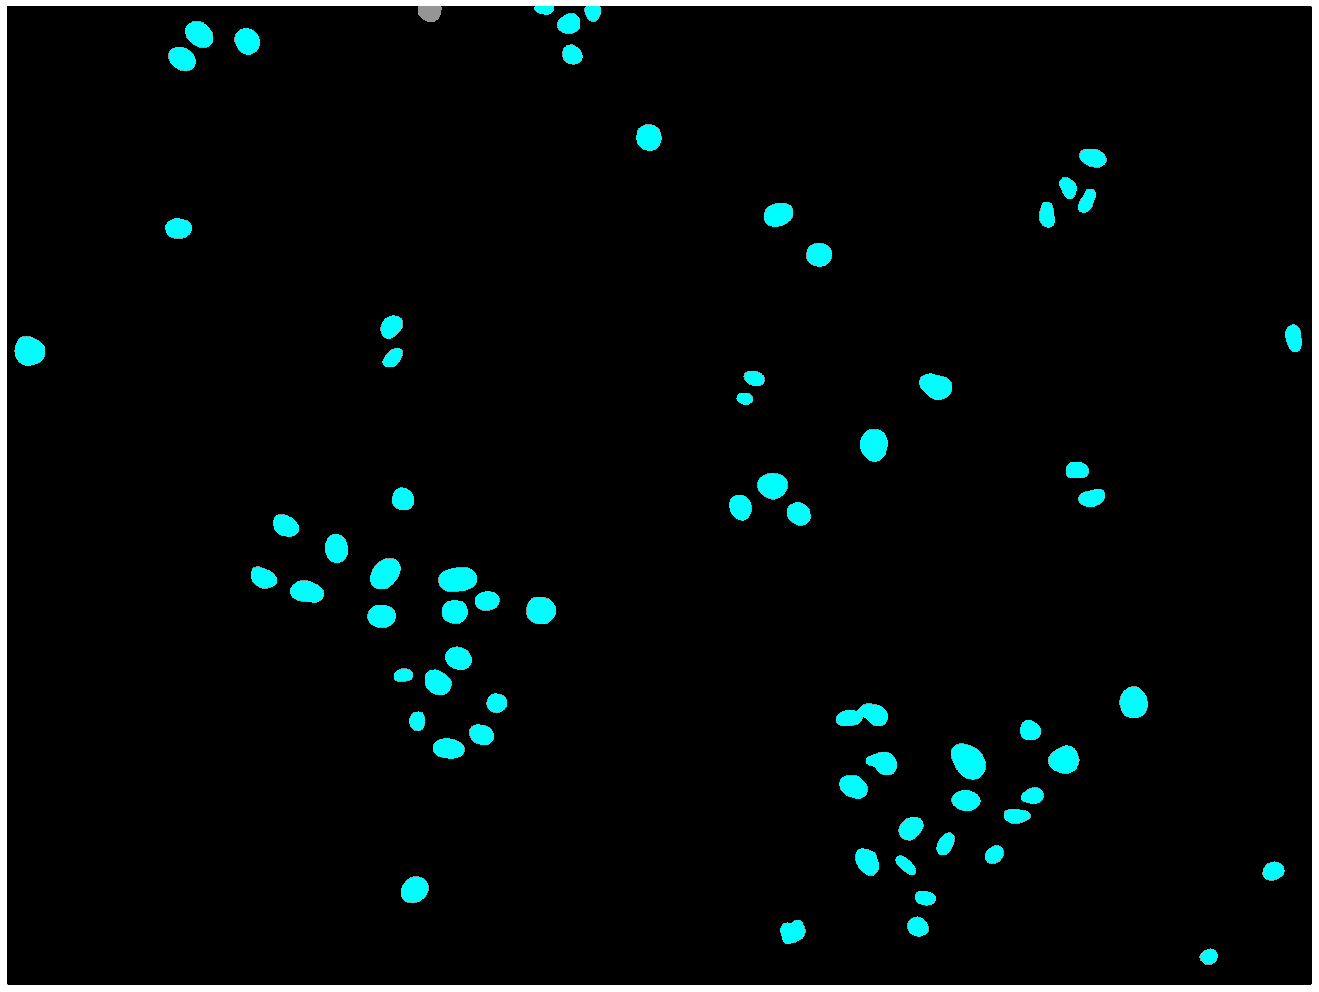

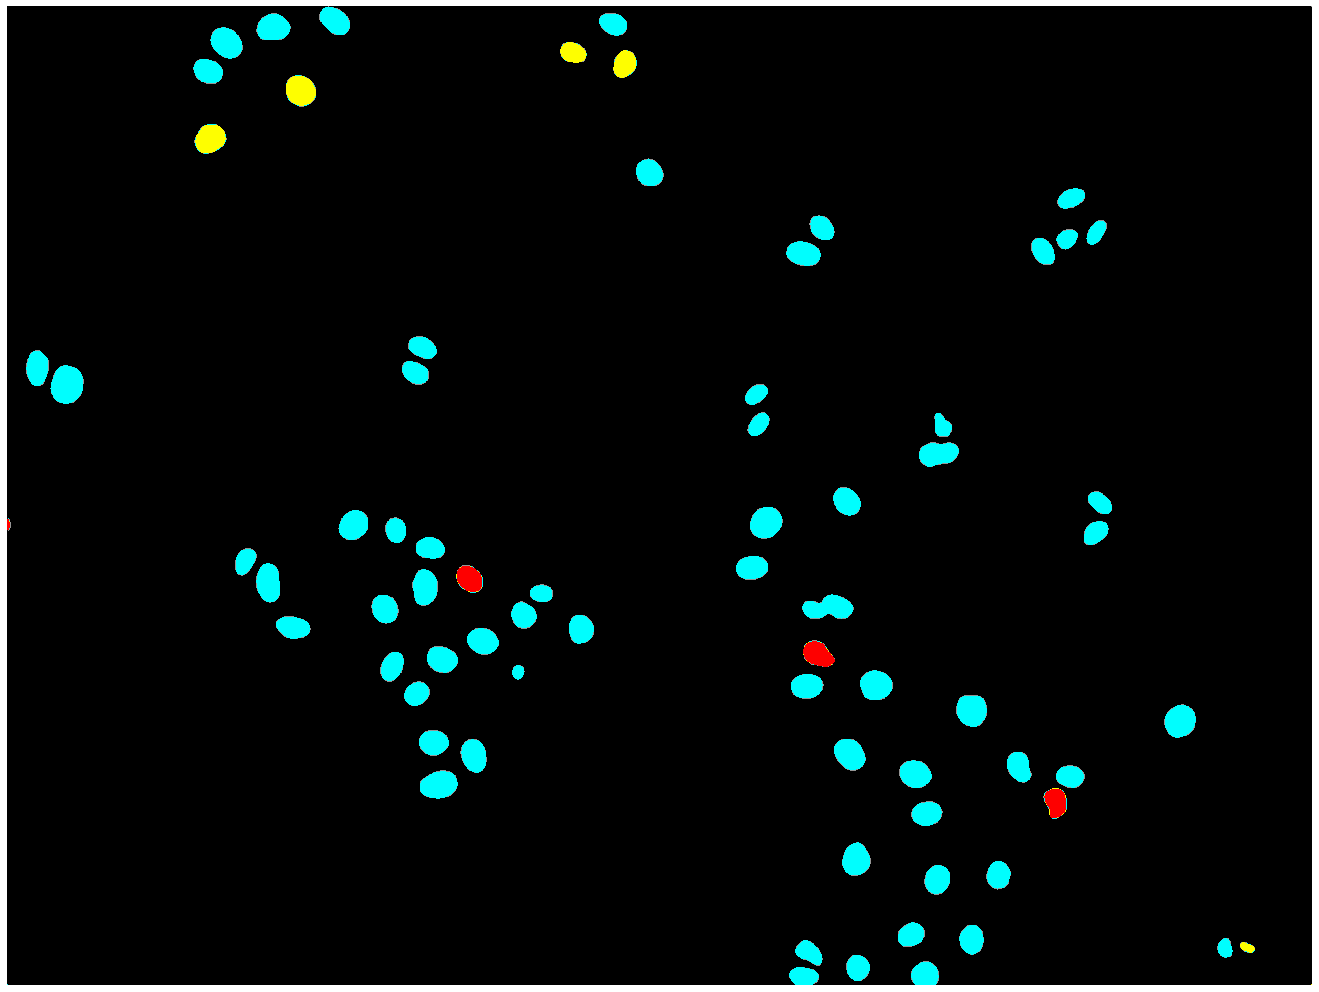

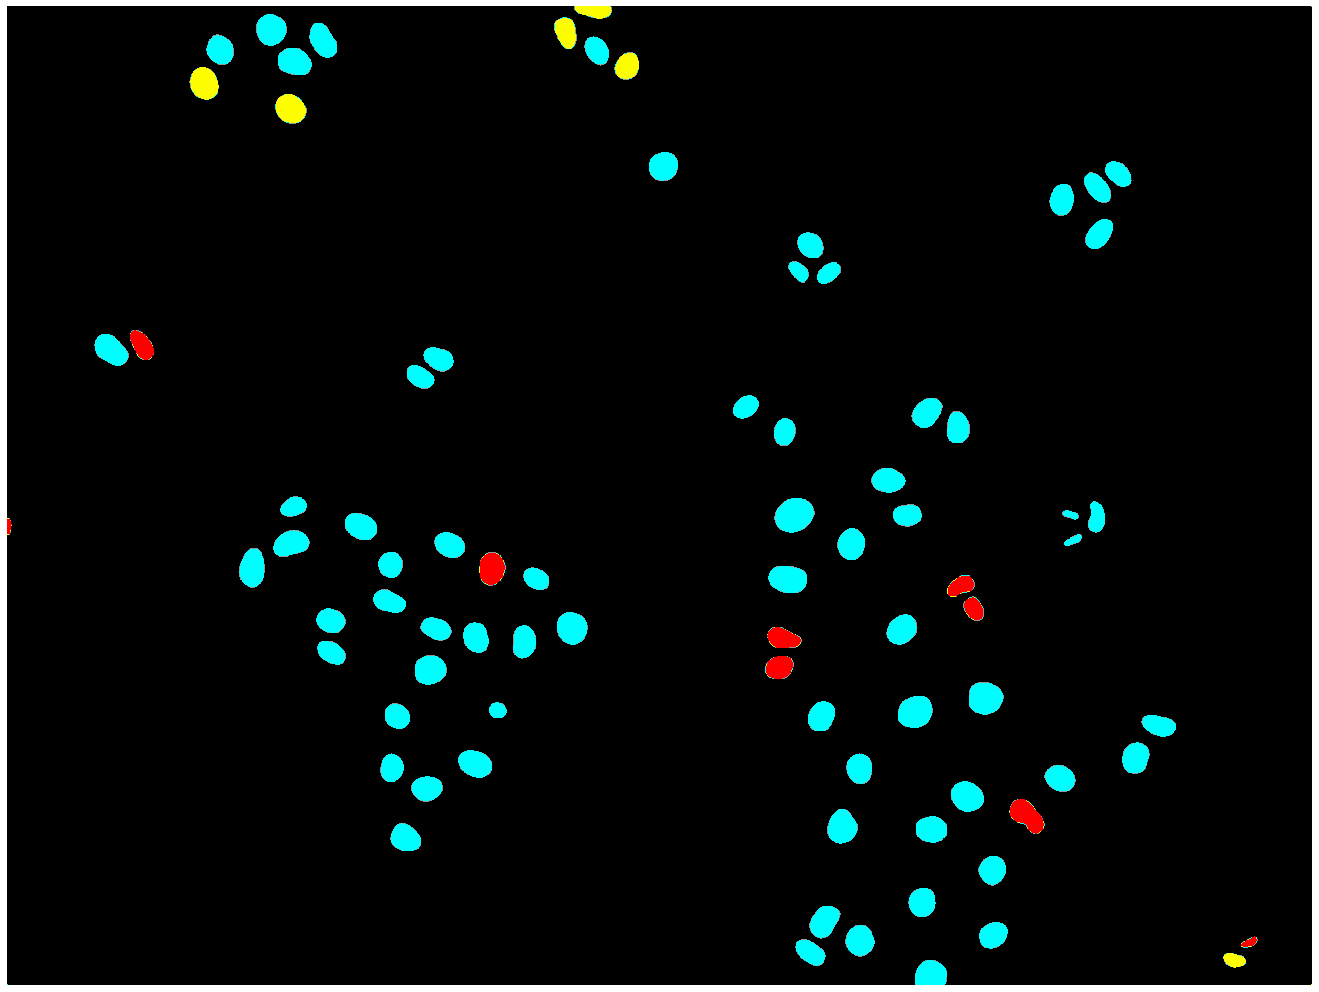

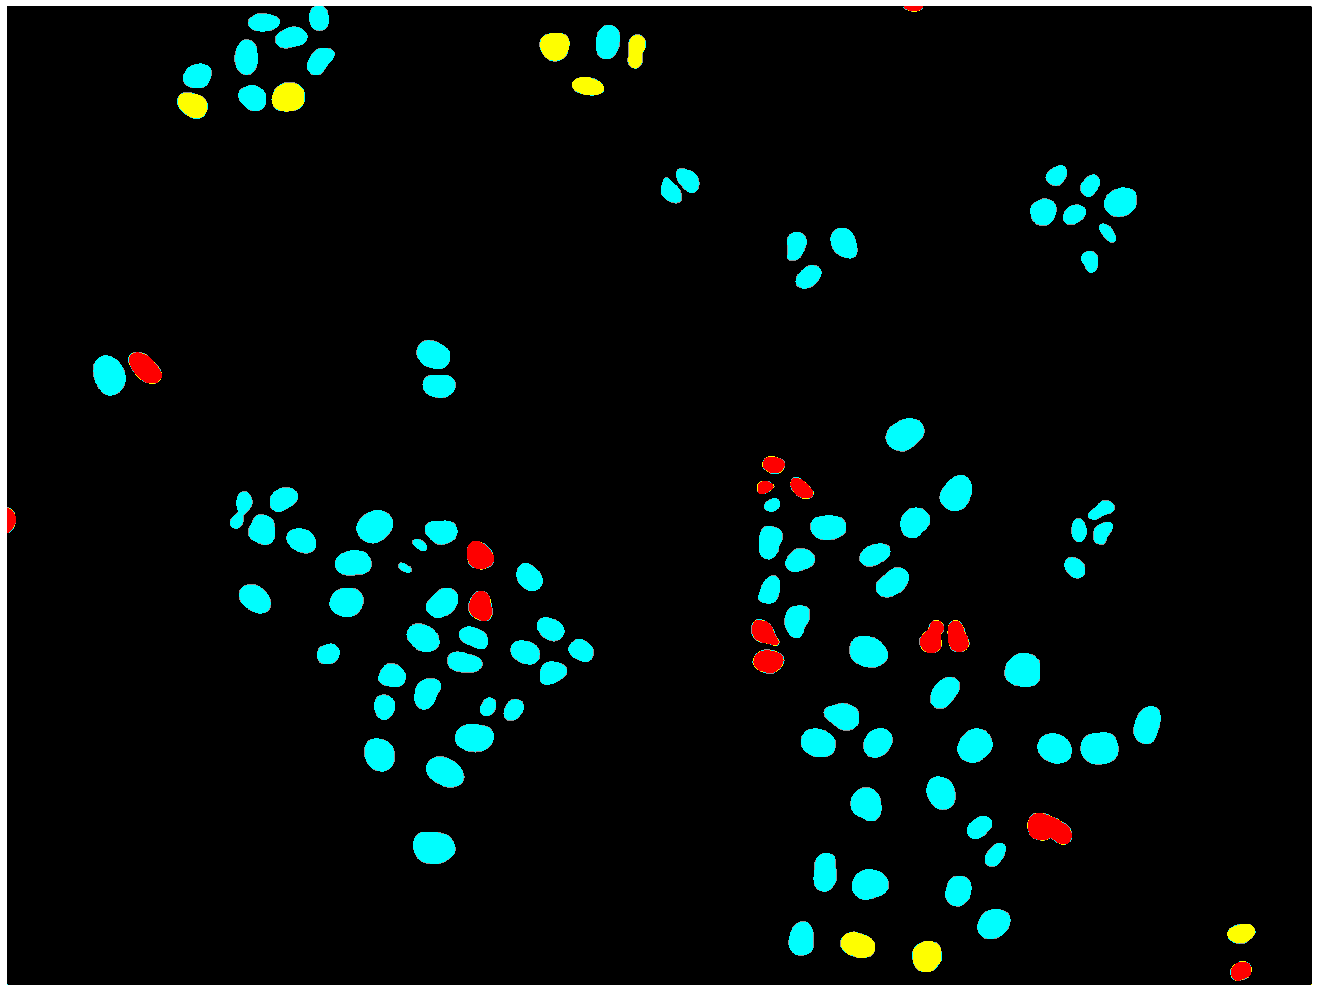

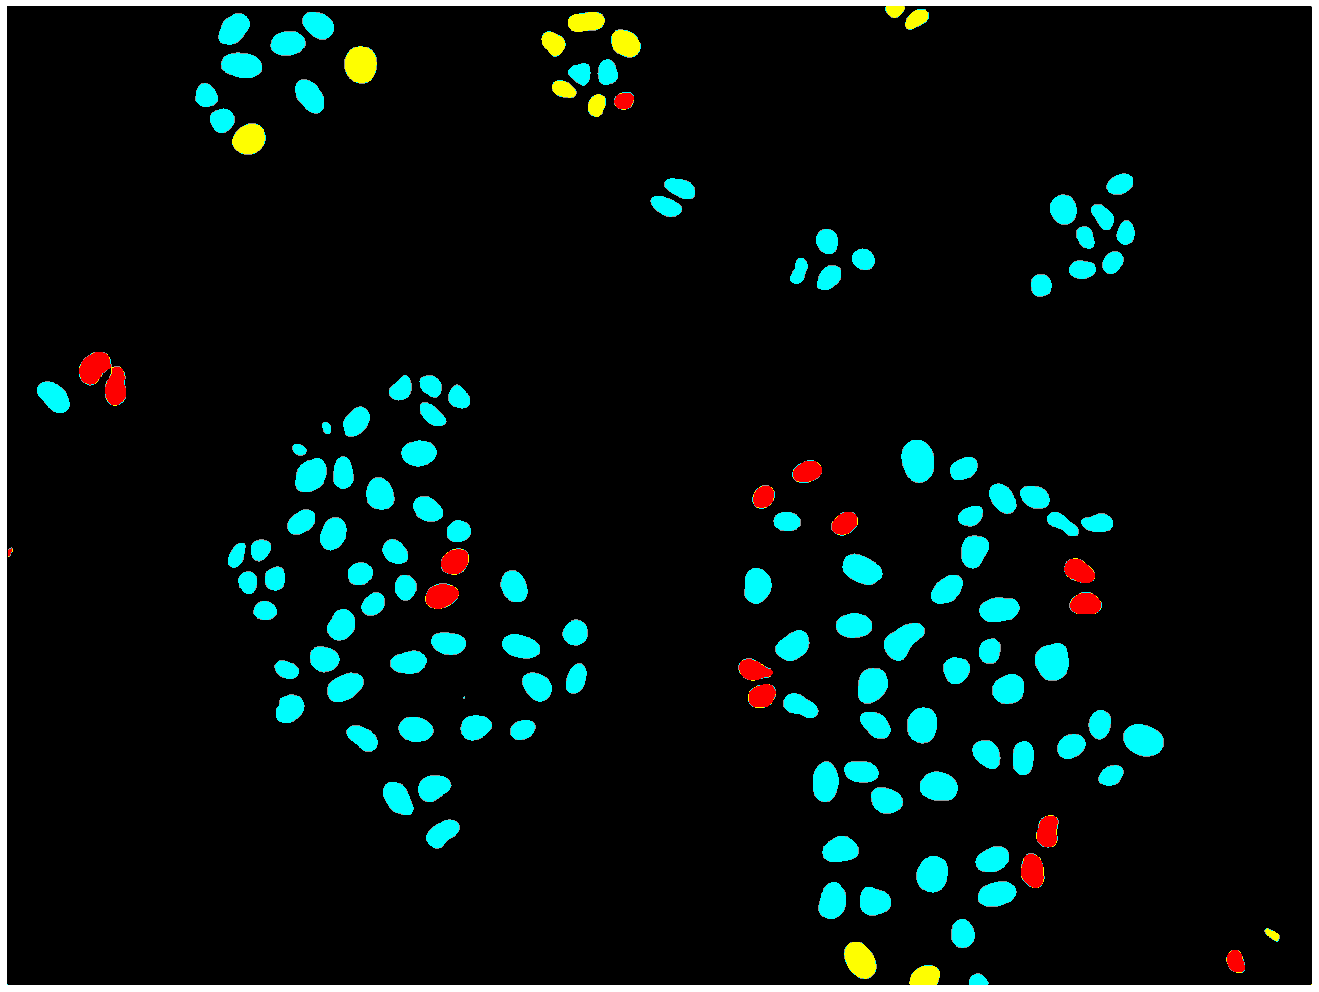

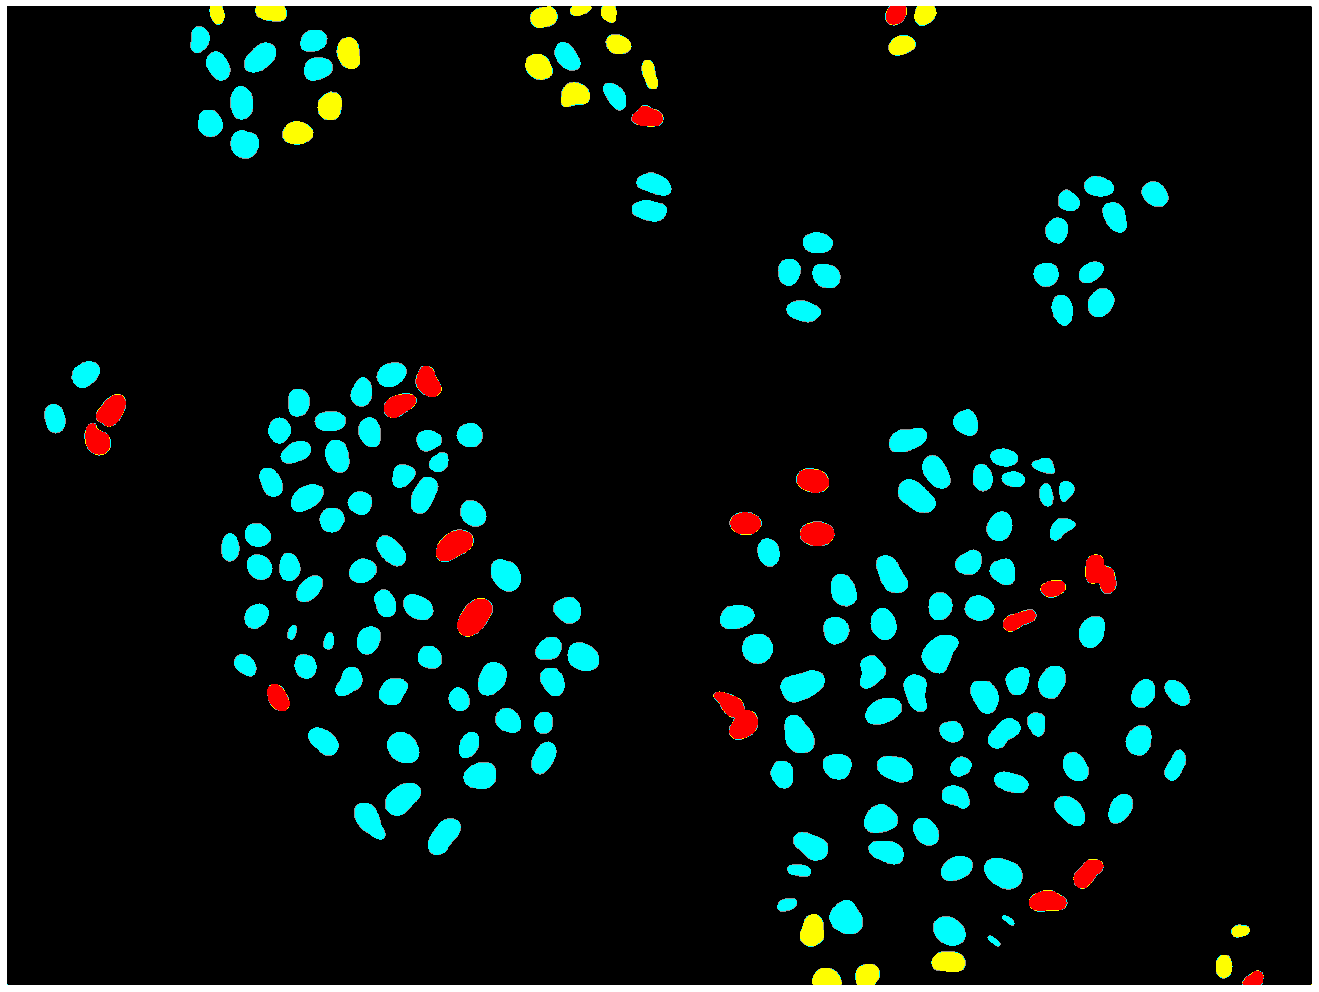

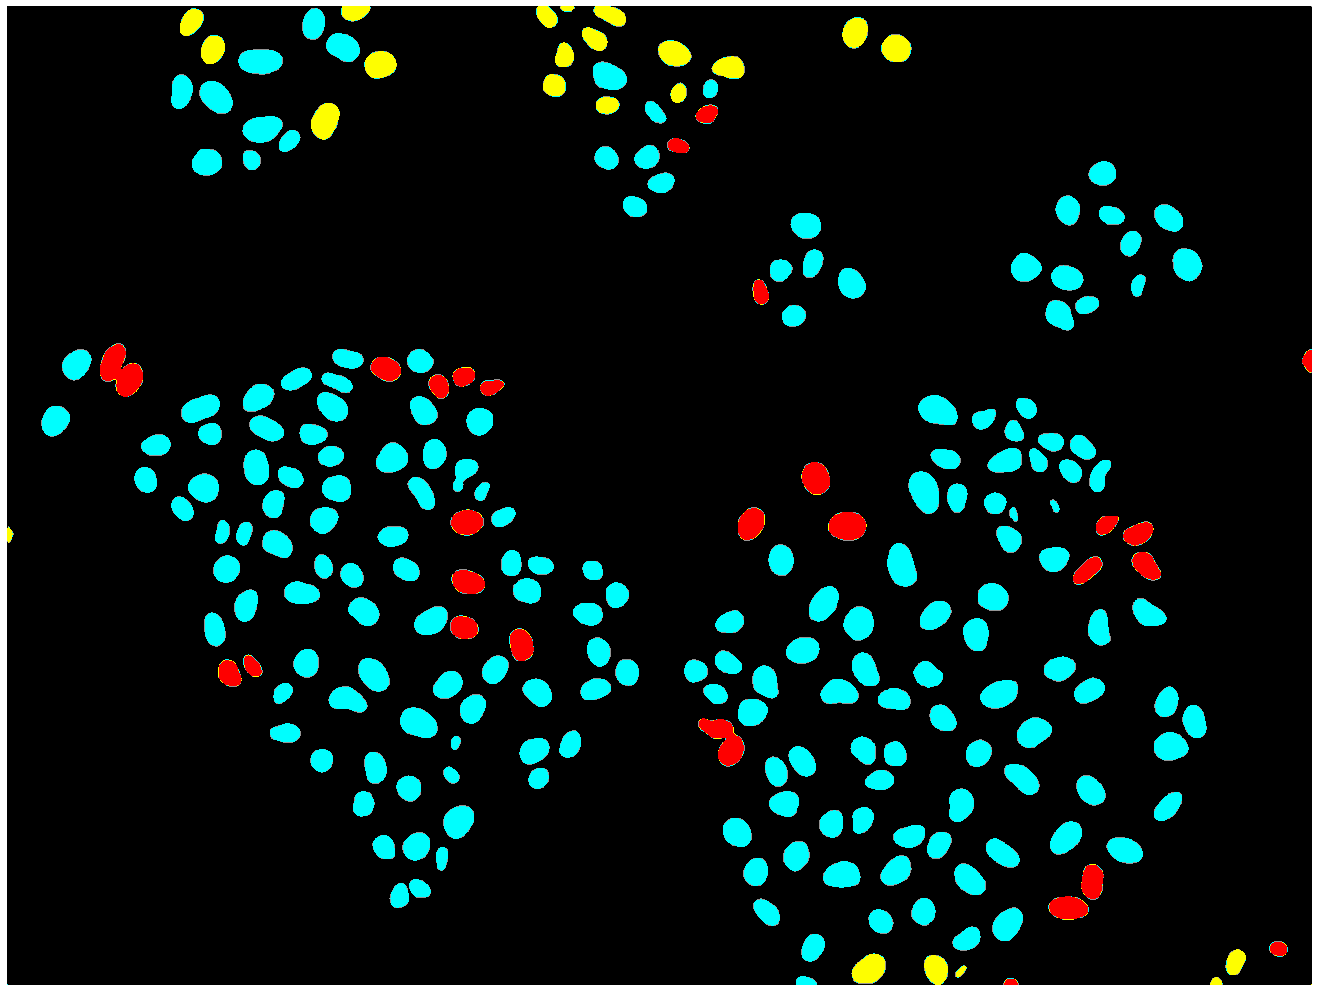

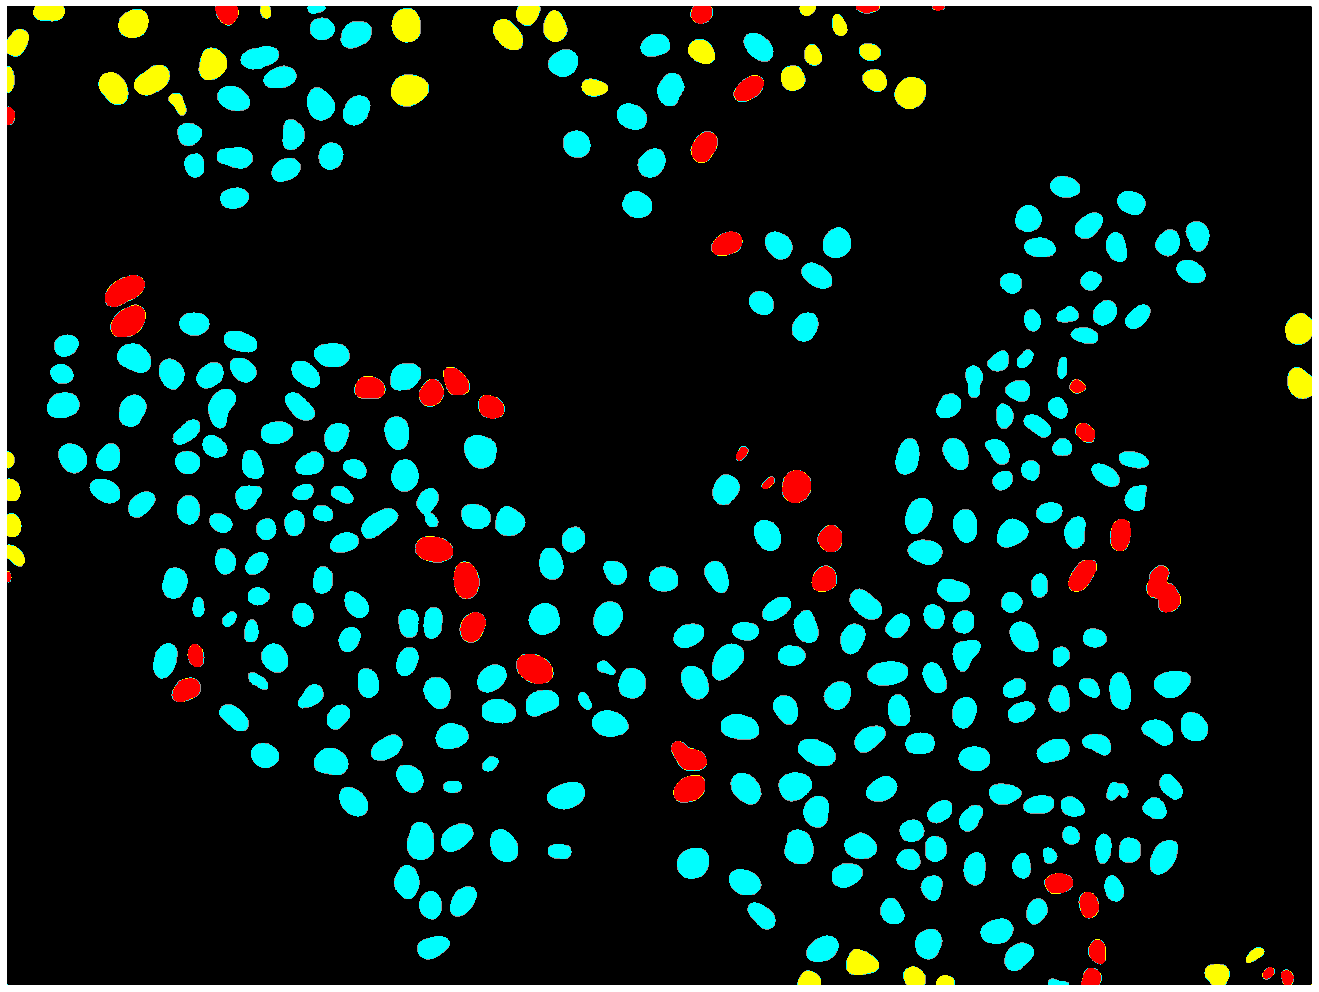

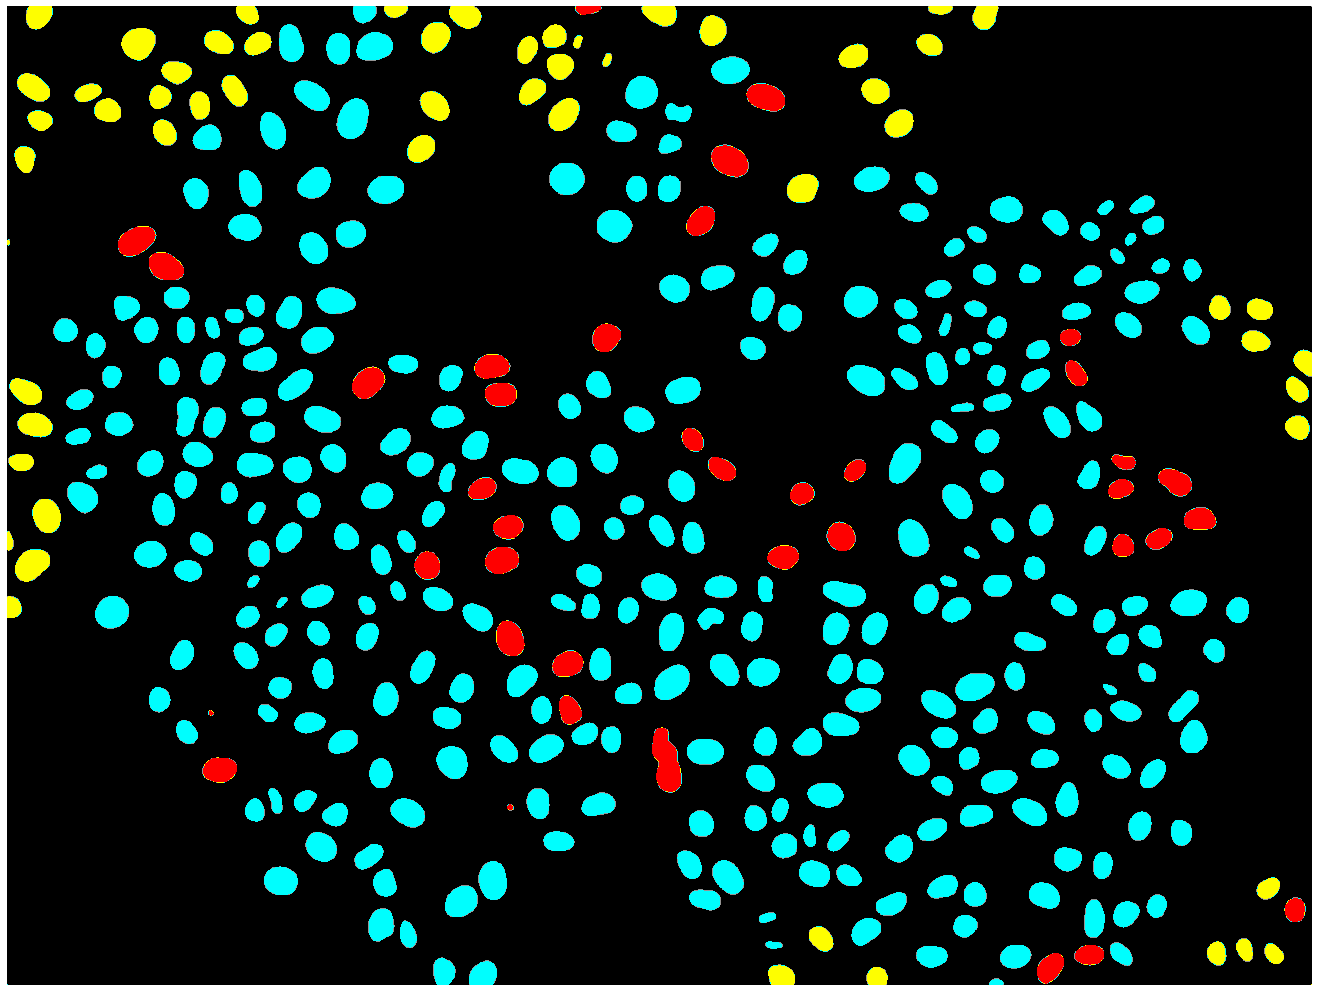

In [8]:
with h5py.File(hdf5_file, 'r') as f:
    
    for frame in frames:
    
        _ = plt.figure(figsize=(24, 18))
        img = f["segmentation"]["images"][frame]
        
        # Process the image: label individual objects & store their slices:
        lbl_image = sp.ndimage.label(img)[0]
        found_objects = sp.ndimage.find_objects(input=lbl_image)
        
        # Map the coordinates:
        mp = f["objects"]["obj_type_1"]["map"][frame]
        coords_list = f["objects"]["obj_type_1"]["coords"][mp[0]:mp[1]]
        fill_list = object_vector[mp[0]:mp[1]]
        
        # Check whether number of detected objects matches found objects in labeled array:
        if len(coords_list) != len(found_objects):
            raise ValueError
        
        # Iterate:
        for e, (obj, lab, slc) in enumerate(zip(coords_list, fill_list, found_objects)):
            
            if not (slc[0].start <= obj[1] <= slc[0].stop and slc[1].start <= obj[2] <= slc[1].stop):
                raise Exception("Warning")
                
            # Check if the pixel at the centre of your cell in non-zero:
            seed_point = img[int(obj[1])][int(obj[2])]
            if seed_point != 0:
                flood_fill(image=img, seed_point=(int(obj[1]), int(obj[2])), new_value=lab, in_place=True)
            else:
                idx = list(lbl_image[slc[0].start][slc[1].start:slc[1].stop]).index(e+1)
                seed_point = img[slc[0].start][slc[1].start+idx]
                if seed_point != 0:
                    flood_fill(image=img, seed_point=(slc[0].start, slc[1].start+idx), new_value=lab, in_place=True)
                else:
                    print ("Disaster!")
        
        # Colormap will normalise its range: include corner pixels with different colors:
        img[0][0] = 1
        img[0][1599] = 2
        img[1199][0] = 3
        img[1199][1599] = 4

        plt.axis("off")
        plt.imshow(img, cmap=newcmp)
        #plt.imsave(fname=dr+f"frm_{frame}.tiff", arr=img, cmap=newcmp)
        

### Done!